In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import petl as etl
import anhima
import zarr
import allel
import itertools
import random
import seaborn as sns
import petlx.bio
import csv
import scipy
import intervaltree

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/sklearn/utils/fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
call = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic')
out_alleles = h5py.File('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.h5')
ac_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/phase2_biallel_allele_count.zarr/')
out_count = zarr.open('/mnt/70D89269D8922CFA/Genomes/extras/outgroup_alleles_phase2.zarr/')
annotation = zarr.open('/mnt/70D89269D8922CFA/Genomes/variation/ag1000g.phase2.ar1.pass.biallelic_snpeff/')
samples = list(call['3L/samples'])
contigs = ['3L', '3R', '2R', '2L', 'X']
samples = [str(s) for s in call["3L"]["samples"][:]]
tbl_samples = etl.fromcsv('/mnt/70D89269D8922CFA/Genomes/meta/samples.meta.txt', delimiter='\t')

In [3]:
tbl_samples

ox_code,src_code,population,country,location,site,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,ebi_sample_acc,latitude,longitude
AA0040-C,Twifo_Praso__E2,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95033368,30.99,ERS311878,5.60858,-1.54926
AA0041-C,Twifo_Praso__H3,GHcol,Ghana,Twifo Praso,Twifo Praso,David Weetman,David Weetman,2012,M,F,95843804,31.7,ERS311886,5.60858,-1.54926
AA0042-C,Takoradi_C7,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,107420666,35.65,ERS311894,4.91217,-1.77397
AA0043-C,Takoradi_H8,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,95993752,29.46,ERS311902,4.91217,-1.77397
AA0044-C,Takoradi_D10,GHcol,Ghana,Takoradi,Takoradi,David Weetman,David Weetman,2012,M,F,103044262,33.67,ERS311910,4.91217,-1.77397


----------------------

In [4]:
m = tbl_samples.select(lambda r: r.m_s == 'M' and r.population == 'AOcol').values('ox_code').list()
s = tbl_samples.select(lambda r: r.m_s == 'S' and r.population == 'GAgam').values('ox_code').list()
index_m = [samples.index(i) for i in m]
index_s = [samples.index(i) for i in s]

In [5]:
print('coluzzii samples:', len(index_m), '\n', 'gambiae samples:', len(index_s))

coluzzii samples: 78 
 gambiae samples: 69


In [6]:
ann = {chrom: annotation[chrom]['variants/ANN_Annotation'][:] for chrom in contigs}

In [7]:
sel = {chrom: ((ann[chrom] != b'intergenic_variant') & (ann[chrom] != b'upstream_gene_variant') &
(ann[chrom] != b'downstream_gene_variant')) for chrom in contigs}

In [8]:
del ann

In [9]:
#Changed from GenotypeDaskArray to GenotypeChunkedArray
ga = {chrom: allel.GenotypeChunkedArray(call[chrom]['calldata/GT']) for chrom in contigs}

In [10]:
# bool biallelic and in genes
is_bial_genes = {chrom: sel[chrom] for chrom in contigs}

In [11]:
#filter to get only biallelic in genes
ga = {chrom: ga[chrom].compress(is_bial_genes[chrom], axis=0) for chrom in contigs}

In [12]:
# get just bf coluzzii individuals
random_index = random.sample(index_m, 69)
gm = {chrom: ga[chrom].take(random_index, axis=1) for chrom in contigs}

In [13]:
#take an equal number of samples
gs = {chrom: ga[chrom].take(index_s, axis=1) for chrom in contigs}

In [14]:
acm = {chrom: gm[chrom].count_alleles() for chrom in contigs}
seg_m = {chrom: acm[chrom].count_segregating() for chrom in contigs}
is_seg_m = {chrom: acm[chrom].is_segregating() for chrom in contigs}

In [15]:
acs = {chrom: gs[chrom].count_alleles() for chrom in contigs}
seg_s = {chrom: acs[chrom].count_segregating() for chrom in contigs}
is_seg_s = {chrom: acs[chrom].is_segregating() for chrom in contigs}

In [16]:
for chrom in contigs:
    print('seg sites coluzii chrom %s:' % chrom, seg_m[chrom])

seg sites coluzii chrom 3L: 887339
seg sites coluzii chrom 3R: 1184963
seg sites coluzii chrom 2R: 1240012
seg sites coluzii chrom 2L: 950572
seg sites coluzii chrom X: 347039


In [17]:
for chrom in contigs:
    print('seg sites gambiae chrom %s:' % chrom, seg_s[chrom])

seg sites gambiae chrom 3L: 1146616
seg sites gambiae chrom 3R: 1635111
seg sites gambiae chrom 2R: 1752127
seg sites gambiae chrom 2L: 1195164
seg sites gambiae chrom X: 369285


In [18]:
#allele frequency
af_gambiae = {chrom: acs[chrom].to_frequencies() for chrom in contigs}

In [19]:
#allele frequency
af_coluzzii = {chrom: acm[chrom].to_frequencies() for chrom in contigs}

In [20]:
outgroups = ['epir', 'chri', 'meru', 'mela']

In [21]:
pos = {chrom: call[chrom]['variants/POS'][:] for chrom in contigs}
pos_bial_genes = {chrom: np.compress(is_bial_genes[chrom], pos[chrom]) for chrom in contigs}

In [22]:
segreg_c = {chrom: np.compress(is_seg_m[chrom], pos_bial_genes[chrom]) for chrom in contigs}
segreg_g = {chrom: np.compress(is_seg_s[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [23]:
# af biallelic in genes
af_out = {}
for out in outgroups:
    af_out[out] = {}
    for chrom in contigs:
        allele_count = out_count[chrom][out][:]
        allele_count_bial_genes = np.compress(is_bial_genes[chrom], allele_count, axis=0)
        allele_number = allele_count_bial_genes.sum(axis=1)[:, np.newaxis]
        af_out[out][chrom] = np.where(allele_number > 0, allele_count_bial_genes / allele_number, 0)

/home/randomx/.conda/envs/pyenv1/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


In [24]:
#filter bial in genes
out_al = {}
for chrom in contigs:
    out_al[chrom] = {}
    for out in outgroups:
        out_al[chrom][out] = out_alleles[chrom][out][:]
        out_al[chrom][out] = np.compress(is_bial_genes[chrom], out_al[chrom][out])

In [25]:
assert out_al[chrom][out].shape[0] == af_out[out][chrom].shape[0]

In [26]:
def consensus_aa(chrom, out_alleles, outgroups):
    aa = None
    for out in outgroups:
        if aa is None:
            aa = out_alleles[chrom][out]
        else:
            loc_consensus = aa == out_alleles[chrom][out]
            aa[~loc_consensus] = b'.'
    return aa

In [27]:
aa = {chrom: consensus_aa(chrom, out_al, ['chri']) for chrom in contigs}

In [28]:
# load ag1000g alleles
ref = {chrom: call[chrom]['variants/REF'][:] for chrom in contigs}
alt = {chrom: call[chrom]['variants/ALT'][:] for chrom in contigs}

In [29]:
# filter for bial in genes
ref_bial_genes = {chrom: np.compress(is_bial_genes[chrom], ref[chrom]) for chrom in contigs}

alt_bial_genes = {chrom: np.compress(is_bial_genes[chrom], alt[chrom]) for chrom in contigs}

In [30]:
bool_aa_match = {chrom: (aa[chrom] != b'.') & ((aa[chrom] == ref_bial_genes[chrom]) | (aa[chrom] == alt_bial_genes[chrom])) for chrom in contigs}

In [31]:
for chrom in contigs:
    ref[chrom] = ref_bial_genes[chrom][bool_aa_match[chrom]]
    alt[chrom] = alt_bial_genes[chrom][bool_aa_match[chrom]]
    af_coluzzii[chrom] =  af_coluzzii[chrom].compress(bool_aa_match[chrom], axis=0)
    af_gambiae[chrom] = af_gambiae[chrom].compress(bool_aa_match[chrom], axis=0)
    aa[chrom] = aa[chrom][bool_aa_match[chrom]]
    pos_bial_genes[chrom] = pos_bial_genes[chrom][bool_aa_match[chrom]]
    out = 'chri'
    af_out[out][chrom] = af_out[out][chrom][bool_aa_match[chrom]]

In [32]:
bool_no_fixed = {chrom:(((af_out['chri'][chrom][:,1]  != 0) & (af_out['chri'][chrom][:,1] != 1)) 
                        ) for chrom in contigs}

In [33]:
af_gambiae_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_gambiae[chrom], axis=0) for chrom in contigs}
af_coluzzii_novar_out = {chrom: np.compress(~bool_no_fixed[chrom], af_coluzzii[chrom], axis=0) for chrom in contigs}
af_novar_out = {}
for out in ['chri']:
        af_novar_out[out] = {chrom: np.compress(~bool_no_fixed[chrom], af_out[out][chrom], axis=0) for chrom in contigs}     

In [34]:
pos_bial_genes = {chrom: np.compress(~bool_no_fixed[chrom], pos_bial_genes[chrom]) for chrom in contigs}

In [35]:
def find_private_fixed_derived_gambiae(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_coluzzii[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                                   
                        

In [36]:
def find_private_fixed_derived_coluzzii(pos, af_gambiae, af_coluzzii, af_out, DAF=0.9):
    fixed = {}
    for chrom in contigs:
        cond = ((abs(af_gambiae[chrom][:, 0] - af_coluzzii[chrom][:, 0]) >= DAF) & 
                (abs(af_gambiae[chrom][:, 0] - af_novar_out['chri'][chrom][:, 0]) <= (1 - DAF)))
        fixed[chrom] = np.compress(cond, pos[chrom])
    return fixed
                 

In [37]:
chrom = 'X'
assert(af_gambiae_novar_out[chrom].shape[0] == af_gambiae_novar_out[chrom].shape[0] == pos_bial_genes[chrom].shape[0])

## Sanity Check

In [38]:
fixed_g = find_private_fixed_derived_gambiae(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_g['3L']

array([ 5528640, 10952921, 11989794, 16556513, 17163911, 25060879,
       34883729, 34883742, 34884498, 35726249, 35726457, 35726718,
       35726743, 35813922, 35814861, 35814873, 35815019, 41365173, 41775147], dtype=int32)

In [39]:
fixed_c = find_private_fixed_derived_coluzzii(pos_bial_genes, af_gambiae_novar_out, af_coluzzii_novar_out, af_novar_out)
fixed_c['3L']

array([ 5527611, 11990120, 16557333, 16564670, 16690981, 17600983,
       25060148, 25063740, 25070089, 25154529, 25154874, 29253861,
       29253926, 29267523, 35721577, 35726424, 35726750, 35726960,
       35736128, 35813220, 35813317, 35813913, 37162424, 39682874, 39801601], dtype=int32)

In [40]:
loc_3L = np.in1d(pos_bial_genes['3L'], fixed_c['3L'])
np.compress(loc_3L, af_coluzzii_novar_out['3L'], axis=0)[:10]

array([[ 0.02898551,  0.97101449],
       [ 0.07971014,  0.92028986],
       [ 0.97101449,  0.02898551],
       [ 0.99275362,  0.00724638],
       [ 0.94202899,  0.05797101],
       [ 0.        ,  1.        ],
       [ 0.03623188,  0.96376812],
       [ 0.07246377,  0.92753623],
       [ 0.94202899,  0.05797101],
       [ 0.98550725,  0.01449275]])

In [41]:
np.compress(loc_3L, af_gambiae_novar_out['3L'], axis=0)[:10]

array([[ 0.93478261,  0.06521739],
       [ 0.99275362,  0.00724638],
       [ 0.03623188,  0.96376812],
       [ 0.05797101,  0.94202899],
       [ 0.02173913,  0.97826087],
       [ 0.92028986,  0.07971014],
       [ 0.94202899,  0.05797101],
       [ 1.        ,  0.        ],
       [ 0.01449275,  0.98550725],
       [ 0.07971014,  0.92028986]])

In [42]:
np.compress(loc_3L, af_novar_out['chri']['3L'], axis=0)[:10,:2]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.]])

-----------------------------

## Stat

In [43]:
def identify_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    return interval_join

In [44]:
identify_fixex_coluzzii = {chrom: identify_variants_per_gene(chrom, fixed_c, 'coluzzii_segreg') for chrom in contigs}

In [45]:
identify_fixex_gambiae = {chrom: identify_variants_per_gene(chrom, fixed_g, 'coluzzii_segreg') for chrom in contigs}

In [46]:
def count_variants_per_gene(chrom, pos, species):
    gff = petlx.bio.gff3.fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    gff_chrom = gff.select(lambda r: r.seqid == '%s' % chrom and r.end > r.start and r.type == 'gene')
    array = np.core.records.fromarrays([pos[chrom]], names= 'pos')
    tbl_pos = etl.fromarray(array).convert('pos', int)
    interval_join = etl.intervaljoin(tbl_pos, gff_chrom, lstart='pos', lstop='pos', rstart='start', rstop='end', include_stop=True).sort('pos')
    genes_names = [x["ID"] for x in interval_join['attributes']]
    interval_join = interval_join.addcolumn('genes', genes_names)
    aggregate = interval_join.aggregate('genes', len).rename('value', species)
    return aggregate

In [47]:
#A
count_segreg_coluzzii = {chrom: count_variants_per_gene(chrom, segreg_c, 'coluzzii_segreg') for chrom in contigs}

In [48]:
#B
count_segreg_gambiae = {chrom: count_variants_per_gene(chrom, segreg_g, 'gambiae_segreg') for chrom in contigs}

In [49]:
#C
count_fixed_coluzzii = {chrom: count_variants_per_gene(chrom, fixed_c, 'coluzzii_fixed') for chrom in contigs}

In [50]:
#D
count_fixed_gambiae = {chrom: count_variants_per_gene(chrom, fixed_g, 'gambiae_fixed') for chrom in contigs}

In [51]:
# join (A and C) - (B and D)
joi_seg_fix_coluzzii = {chrom: count_fixed_coluzzii[chrom].join(count_segreg_coluzzii[chrom], key='genes') for chrom in contigs}
joi_seg_fix_gambiae  = {chrom: count_fixed_gambiae[chrom].join(count_segreg_gambiae[chrom], key='genes') for chrom in contigs}

In [52]:
# calculate the ratio for each gene
joi_seg_fix_coluzzii= {chrom: joi_seg_fix_coluzzii[chrom].addfield('A/C (i.e.seg/fix)', lambda r: r.coluzzii_segreg / r.coluzzii_fixed)
                       for chrom in contigs}
joi_seg_fix_gambiae= {chrom: joi_seg_fix_gambiae[chrom].addfield('B/D (i.e.seg/fix)', lambda r: r.gambiae_segreg / r.gambiae_fixed)
                       for chrom in contigs}
joi_seg_fix_coluzzii['2R'].display()
joi_seg_fix_gambiae['2R'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix)
AGAP001410,2,403,201.5
AGAP001412,1,528,528.0
AGAP001609,1,586,586.0
AGAP001658,3,222,74.0
AGAP001660,2,862,431.0


genes,gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP001271,2,364,182.0
AGAP001410,2,661,330.5
AGAP001638,2,122,61.0
AGAP001658,1,405,405.0
AGAP001660,1,1233,1233.0


In [53]:
etl.rowlengths(joi_seg_fix_gambiae['X'])

length,count
4,135


In [54]:
# calculate ABCD genome wide (in all genes with both fixed and segregating variants)
A_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_segreg')[2] for chrom in contigs])
C_geno_wide_coluzzii = sum([joi_seg_fix_coluzzii[chrom].stats('coluzzii_fixed')[2] for chrom in contigs])
B_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_segreg')[2] for chrom in contigs])
D_geno_wide_gambiae = sum([joi_seg_fix_gambiae[chrom].stats('gambiae_fixed')[2] for chrom in contigs])

In [55]:
# calculate A/C and B/D genome wide
AC_geno_wide = A_geno_wide_coluzzii / C_geno_wide_coluzzii
print('\n', 'A genome wide: ', A_geno_wide_coluzzii, '\n', 'C genome wide: ', C_geno_wide_coluzzii, '\n', 'A/C genome wide: ', AC_geno_wide)
BD_geno_wide = B_geno_wide_gambiae / D_geno_wide_gambiae
print('\n', 'B genome wide: ', B_geno_wide_gambiae, '\n', 'D genome wide: ', D_geno_wide_gambiae, '\n', 'B/D genome wide: ', BD_geno_wide)


 A genome wide:  250852.0 
 C genome wide:  1678.0 
 A/C genome wide:  149.49463647199048

 B genome wide:  241385.0 
 D genome wide:  1085.0 
 B/D genome wide:  222.47465437788017


In [56]:
def get_conti(chrom, species, joi_seg_fix, seg_geno_wide, fixed_geno_wide):
    conti_tbl = {}
    for rec in joi_seg_fix[chrom].records():
        if species == 'coluzzii':
            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            gene = rec.genes
            conti_tbl[gene] = [[A, C], [seg_geno_wide, fixed_geno_wide]]
        if species == 'gambiae':
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[gene] = [[B, D], [seg_geno_wide, fixed_geno_wide]]
    return conti_tbl

In [57]:
def perform_pear_chi(species):
    pear_chi = {}
    conti_tbl = {}
    for chrom in contigs:
        if species == 'coluzzii':
            conti_tbl[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
        if species == 'gambiae':
            conti_tbl[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
        pear_chi[chrom] = {}
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [58]:
pear_chi_coluzzii = perform_pear_chi('coluzzii')
pear_chi_gambiae = perform_pear_chi('gambiae')

In [59]:
conti_tbl_coluzzii = {}
conti_tbl_gambiae = {}
for chrom in contigs:
    conti_tbl_gambiae[chrom] = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    conti_tbl_coluzzii[chrom] = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)

In [60]:
with open('/home/randomx/hka/gambiae_hka_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_g', 'pri_der_fix_g', 'score_g']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_gambiae[chrom].items():
            row = [chrom, gene, conti_tbl_gambiae[chrom][gene][0][0], conti_tbl_gambiae[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


In [61]:
with open('/home/randomx/hka/coluzzii_hka_summary.tab_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene', 'segreg_c', 'pri_der_fix_c', 'score_c']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_coluzzii[chrom].items():
            row = [chrom, gene, conti_tbl_coluzzii[chrom][gene][0][0], conti_tbl_coluzzii[chrom][gene][0][1], -(np.log10((value[1])))]
            writer.writerow(row)


------------------------------------------------------------

In [62]:
hka_gambiae = etl.fromtsv('/home/randomx/hka/gambiae_hka_summary_beta.tab', delimiter='\t')
hka_gambiae.convert('score_g', float).select(lambda rec: rec.score_g >= 1.3).displayall()

chrom,gene,segreg_g,pri_der_fix_g,score_g
3L,AGAP011979,60,3,4.5371462064
3R,AGAP007731,89,10,41.2531184862
3R,AGAP007736,1072,73,182.673353372
3R,AGAP007735,17,2,5.92829285223
3R,AGAP007761,405,19,32.3228268979
3R,AGAP007759,206,4,2.08371211437
3R,AGAP007732,266,32,146.113765502
3R,AGAP007737,53,2,1.94362840955
3R,AGAP007762,45,5,18.8045309737
3R,AGAP009726,2868,1,2.814376814


In [63]:
hka_coluzzii = etl.fromtsv('/home/randomx/hka/coluzzii_hka_summary.tab_beta.tab', delimiter='\t')
hka_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c
3L,AGAP012056,250,1,0.0474047820454
3L,AGAP012289,98,1,0.0731145157304
3L,AGAP011479,368,3,0.00760116645372
3L,AGAP012275,114,1,0.118261609458
3L,AGAP011094,126,1,0.150520397087
3R,AGAP007731,32,11,80.6837701301
3R,AGAP009726,1413,2,1.6187776909
3R,AGAP007743,69,3,2.46936295798
3R,AGAP010292,65,1,0.0333859732914
3R,AGAP007732,91,23,136.081502674


In [64]:
hka_gambiae.convert('score_g', float).select(lambda r: (r.chrom == 'X') & (r.score_g >= 1.3)).rowlengths() 

length,count
5,81


In [65]:
hka_coluzzii.convert('score_c', float).select(lambda r: (r.chrom == 'X') & (r.score_c >= 1.3)).rowlengths() 

length,count
5,65


-----------------------------

## Distruptive selection

In [66]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    #.select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True)
    )
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_beta.tab', delimiter='\t')
direct_select.display(10)

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP007736,681,71,181.682807614,1072,73,182.673353372,364.356160986
3R,AGAP007732,91,23,136.081502674,266,32,146.113765502,282.195268176
X,AGAP001076,44,12,73.5916335543,25,10,121.945975984,195.5376095383
X,AGAP001035,23,14,156.43659735,28,5,29.0075928251,185.4441901751
X,AGAP013341,9,10,152.763730124,18,4,26.6792228057,179.4429529297
X,AGAP001023,57,6,14.4353741539,100,20,144.943785775,159.3791599289
2R,AGAP013121,127,24,110.163784486,167,8,13.4589981806,123.6227826666
3R,AGAP007731,32,11,80.6837701301,89,10,41.2531184862,121.9368886163
2R,AGAP004643,18,7,53.8654341566,18,4,26.6792228057,80.5446569623
X,AGAP001041,3,1,2.4456762214,1,3,76.2388959337,78.6845721551


In [67]:
direct_select = (hka_coluzzii.join(hka_gambiae, key=['chrom', 'gene'])
    .convert(['score_c', 'score_g'], float)
    .select(lambda r: (r.score_g >= 10) & (r.score_c >= 10))
    .addfield('score_tot', lambda r: r.score_c + r.score_g)
    .sort('score_tot', reverse=True))
direct_select.tocsv('/home/randomx/hka/putative_directional_selection_beta.tab', delimiter='\t')
direct_select.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
3R,AGAP007736,681,71,181.682807614,1072,73,182.673353372,364.356160986
3R,AGAP007732,91,23,136.081502674,266,32,146.113765502,282.195268176
X,AGAP001076,44,12,73.5916335543,25,10,121.945975984,195.5376095383
X,AGAP001035,23,14,156.43659735,28,5,29.0075928251,185.4441901751
X,AGAP013341,9,10,152.763730124,18,4,26.6792228057,179.4429529297
X,AGAP001023,57,6,14.4353741539,100,20,144.943785775,159.3791599289
2R,AGAP013121,127,24,110.163784486,167,8,13.4589981806,123.6227826666
3R,AGAP007731,32,11,80.6837701301,89,10,41.2531184862,121.9368886163
2R,AGAP004643,18,7,53.8654341566,18,4,26.6792228057,80.5446569623
X,AGAP001026,19,6,38.5232544454,12,4,36.8860136288,75.4092680742


## Indentify genes which experienced private selection

In [68]:
hka_gambiae_coluzzii = hka_coluzzii.outerjoin(hka_gambiae, key=['chrom', 'gene']).convert(['score_g', 'score_c'], float)
priv_sel_coluzzii =  (hka_gambiae_coluzzii.selectne('score_c', None).convert('score_g', {None: 0})
                     .select(lambda r: r.score_c >= 1.3 and r.score_g <= 1.3).sort('score_c', reverse=True))
priv_sel_coluzzii.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP013181,15,4,20.7421672445,None,None,0
2R,AGAP002824,687,26,20.66570447,1425,8,0.174675049552
X,AGAP000988,2,2,18.8943232593,None,None,0
2R,AGAP004306,20,4,16.2872529205,None,None,0
X,AGAP001025,26,4,12.8934748304,23,1,0.638015763499
2R,AGAP013294,469,16,11.067953566,960,3,0.156686245223
2R,AGAP003479,133,8,10.9404816684,270,3,0.606911799004
2L,AGAP005169,51,5,10.9182717032,None,None,0
X,AGAP000994,16,3,10.6718615807,28,1,0.518153176332
2R,AGAP004275,32,4,10.6253506445,51,1,0.237359317585


In [69]:
priv_sel_gambiae =  (hka_gambiae_coluzzii.selectne('score_g', None).convert('score_c', {None: 0})
                     .select(lambda r: r.score_g >= 1.3 and r.score_c <= 1.3).sort('score_g', reverse=True))
priv_sel_gambiae.displayall()

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000975,None,None,0,13,5,53.942333369
X,AGAP001083,11,1,0.868047859711,7,3,30.4699329669
X,AGAP000837,106,2,0.450340395179,108,9,27.4315459284
2L,AGAP004698,None,None,0,11,3,21.718307862
X,AGAP000010,19,1,0.505135706198,13,3,18.9776377051
3R,AGAP007762,None,None,0,45,5,18.8045309737
X,AGAP001042,None,None,0,5,2,16.0163979357
X,AGAP001030,10,1,0.945986478657,16,3,15.943602337
X,AGAP000986,35,1,0.227042525757,54,5,15.7765421675
X,AGAP001039,20,1,0.477355294556,18,3,14.3999645529


## Plot genome wide HKA

In [70]:
def center_pos(r):
    start = r.start
    end = r.end
    center = ((end - start) / 2) + start
    return int(center)

In [71]:
tbl_genes  = (etl
    .fromgff3('/mnt/70D89269D8922CFA/Genomes/genome/Anopheles-gambiae-PEST_BASEFEATURES_AgamP4.2.gff3.gz')
    .unpackdict('attributes')
    .cut(2,3,4,9)
    .select(lambda rec: rec.type == 'gene')
    .rename('ID', 'gene')
    .addfield('center_gene', center_pos)
)
tbl_genes.display(10)

type,start,end,gene,center_gene
gene,157348,186936,AGAP004677,172142
gene,203779,205293,AGAP004678,204536
gene,207894,210460,AGAP004679,209177
gene,271285,271815,AGAP004680,271550
gene,358329,359280,AGAP004681,358804
gene,433503,461627,AGAP004682,447565
gene,485698,488369,AGAP004683,487033
gene,493039,493543,AGAP004684,493291
gene,493579,497632,AGAP004685,495605
gene,742004,747057,AGAP004686,744530


In [72]:
pos_hka_gambiae = hka_gambiae.join(tbl_genes, key='gene')
pos_hka_coluzzii = hka_coluzzii.join(tbl_genes, key='gene')

In [73]:
def plot_genome_hka(species, chrom):
    if species == 'gambiae':   
        tbl_plot = pos_hka_gambiae.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_g'].list()
    if species == 'coluzzii':
        tbl_plot = pos_hka_coluzzii.select(lambda r: r.chrom == chrom)
        y = tbl_plot['score_c'].list()
    fig, ax = plt.subplots(figsize=(15,2))
    x = tbl_plot['center_gene'].list()
    
    ax.set_ylabel('HKA test score', fontsize=14)
    ax.set_xlabel('Positions', fontsize=14)
    ax.set_title('An. gambiae chrom: %s' % chrom, fontsize=14)
    ax.plot(x, y, 'or')
    len_chrom = {'X': 244e5, '3R': 532e5, '3L': 42e6, '2R': 616e5, '2L':493e5}
    ax.set_xlim(0, len_chrom[chrom])
    if chrom == 'X':
        ax.set_ylim(0, 80)
    else:
        ax.set_ylim(0, 40)
    sns.despine(offset=10)

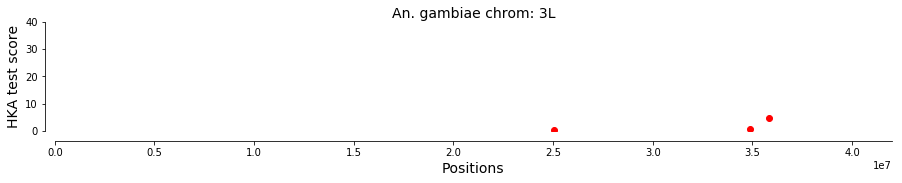

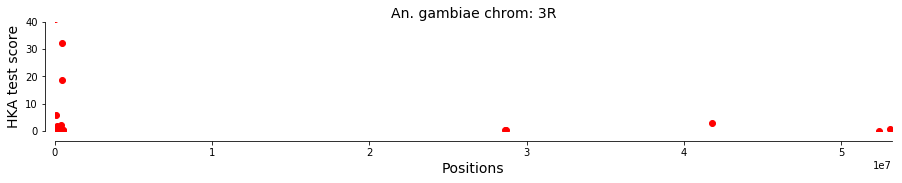

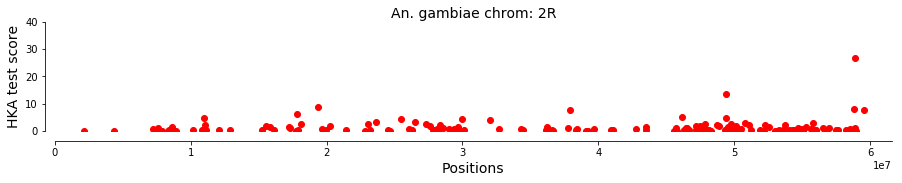

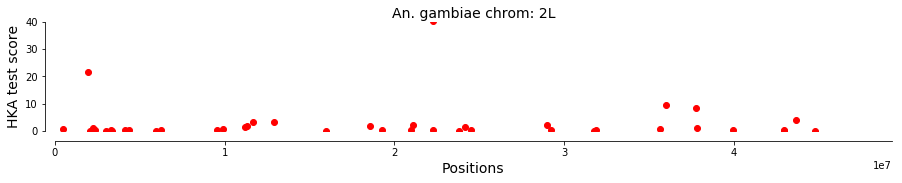

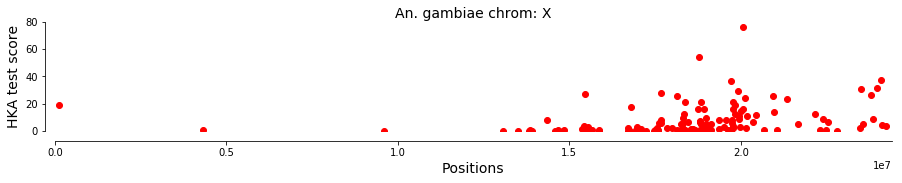

In [74]:
for chrom in contigs:
    plot_genome_hka('gambiae', chrom)

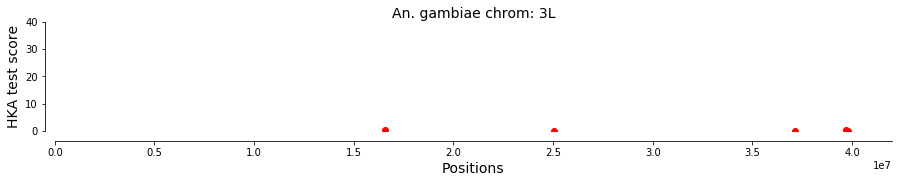

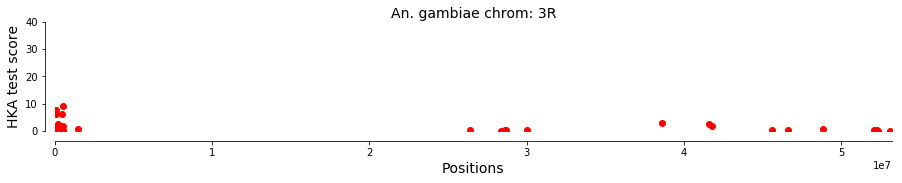

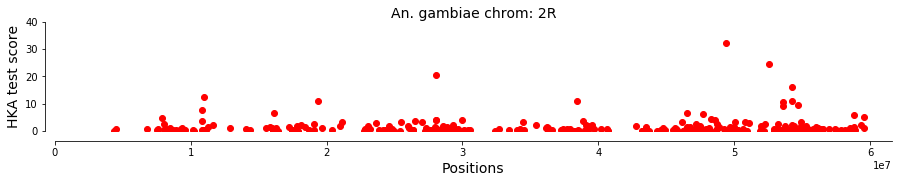

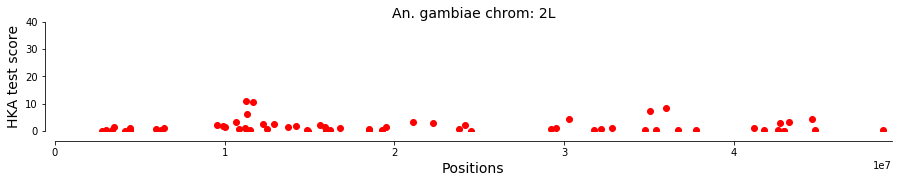

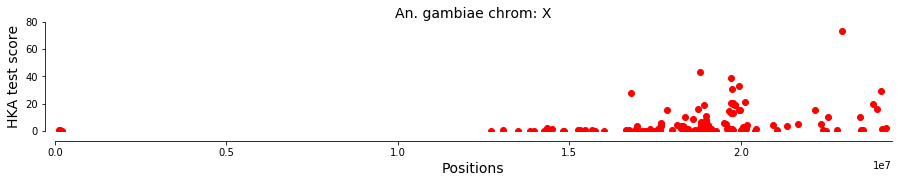

In [75]:
for chrom in contigs:
    plot_genome_hka('coluzzii', chrom)

## Plot seg fixed An coluzzii

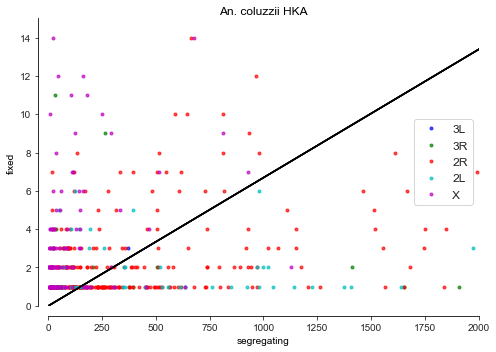

In [76]:
fig, ax = plt.subplots(figsize=(7,5))
for num, chrom in enumerate(contigs):
    
    colour = {0:'b', 1:'g', 2:'r', 3: 'c', 4:'m'}
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed,  colour[num] + '.', alpha=0.7, label=chrom)
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii], 'k')
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('An. coluzzii HKA')
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    ax.legend(loc=7, fontsize='large')
    sns.despine(offset=10)

fig.tight_layout()

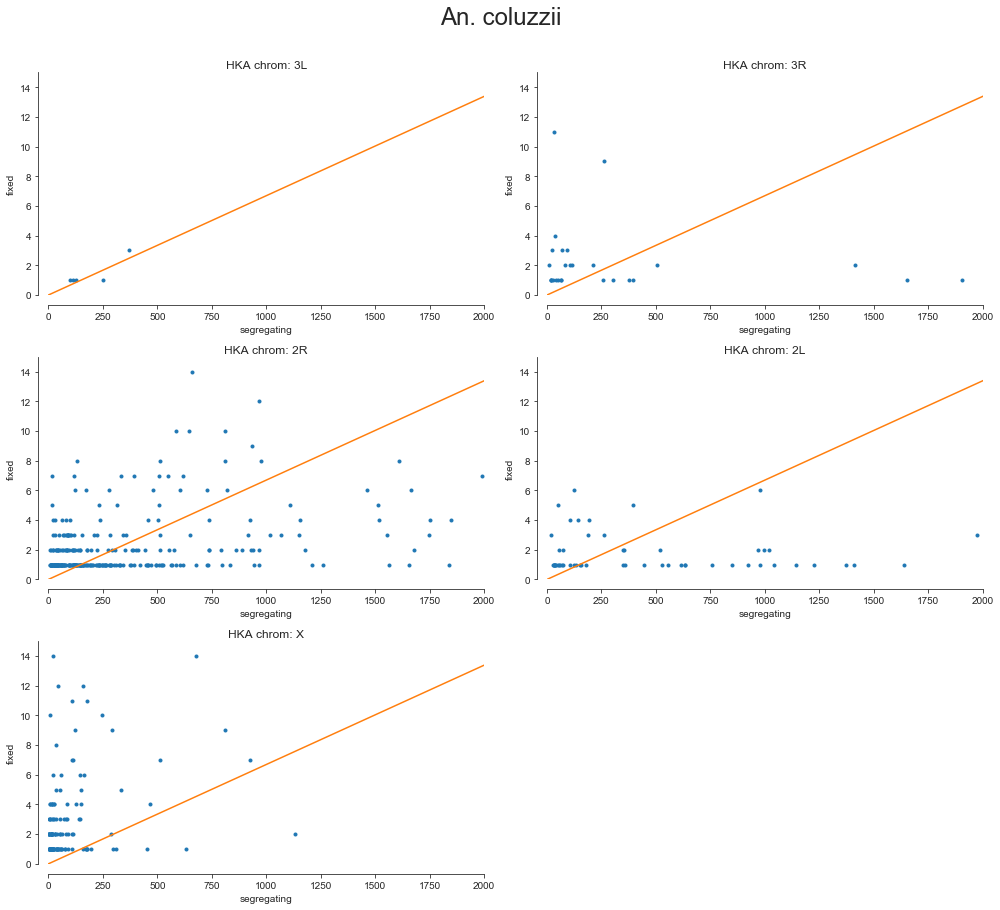

In [77]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'coluzzii', joi_seg_fix_coluzzii, A_geno_wide_coluzzii, C_geno_wide_coluzzii)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, A_geno_wide_coluzzii], [0, C_geno_wide_coluzzii])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. coluzzii', y=1.05, fontsize=24)
fig.tight_layout()

## Plot seg fixed An. gambiae

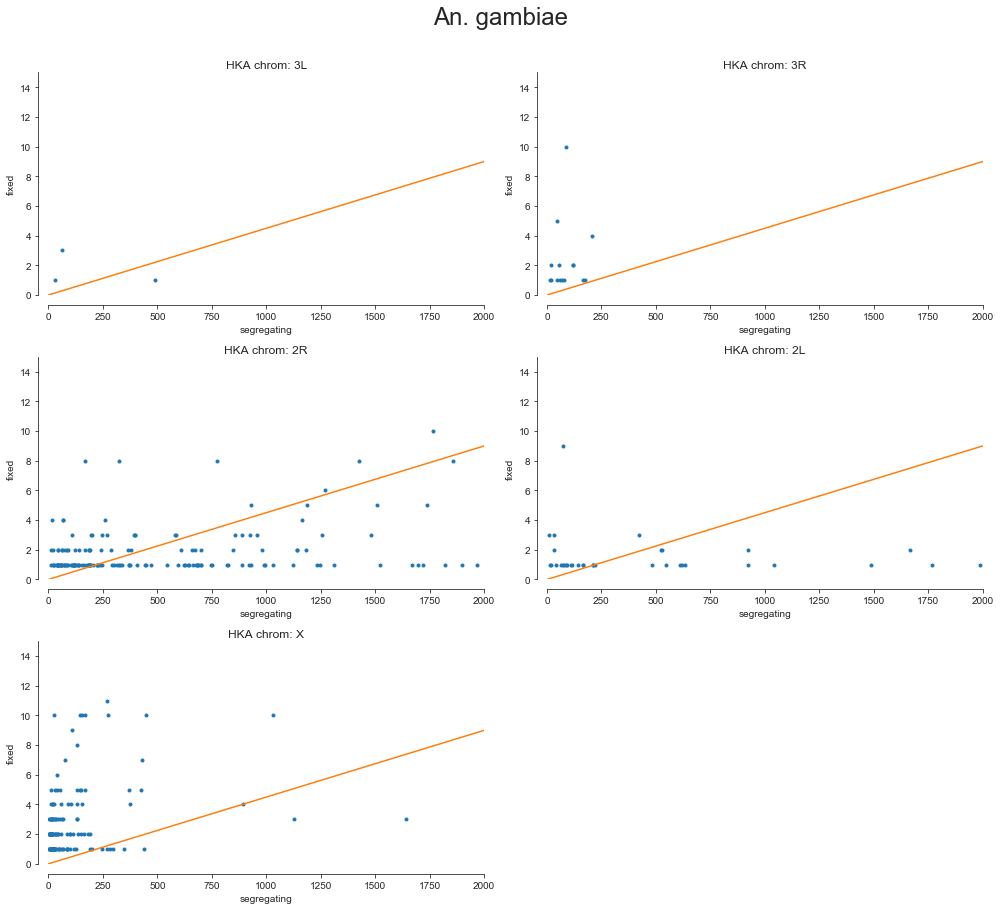

In [78]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    conti_tbl = get_conti(chrom, 'gambiae', joi_seg_fix_gambiae, B_geno_wide_gambiae, D_geno_wide_gambiae)
    segreg = [i[0][0] for i in conti_tbl.values()]
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(segreg, fixed, '.')
    ax.plot([0, B_geno_wide_gambiae], [0, D_geno_wide_gambiae])
    ax.set_xlabel('segregating')
    ax.set_xlim(0,2000)
    ax.set_ylim(0,15)
    ax.set_title('HKA chrom: %s' % chrom)
    ax.set_ylabel('fixed')
    sns.set_style('ticks')
    sns.despine(offset=10)
fig.suptitle('An. gambiae', y=1.05, fontsize=24)
fig.tight_layout()

## Plot homogeneity test

In [79]:
# get just the gene matching gambiae coluzzii
joi_gambiae_coluzzii = {chrom: joi_seg_fix_coluzzii[chrom].join(joi_seg_fix_gambiae[chrom], key='genes') for chrom in contigs}

In [80]:
joi_gambiae_coluzzii['2L'].display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP004827,2,354,177.0,3,422,140.66666666666666
AGAP004915,5,395,79.0,2,525,262.5
AGAP004940,2,517,258.5,1,632,632.0
AGAP005072,4,142,35.5,1,166,166.0
AGAP005091,1,1227,1227.0,1,1041,1041.0


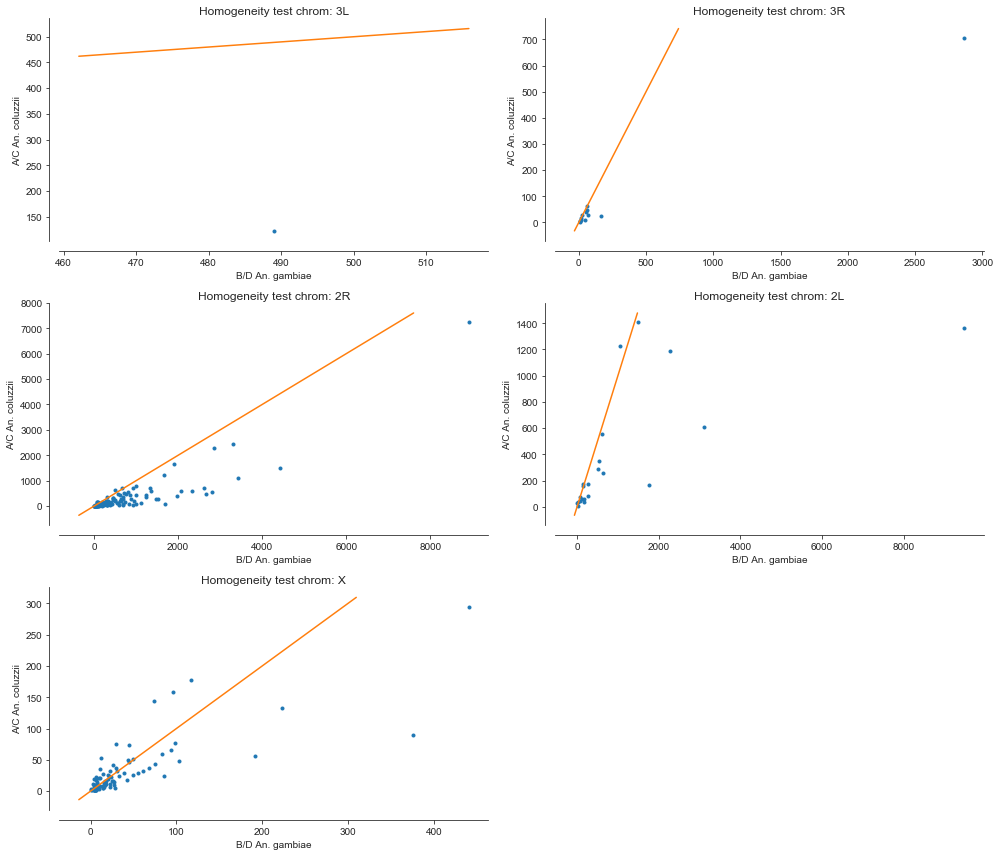

In [81]:
fig = plt.figure(figsize=(14, 12))
for num, chrom in enumerate(contigs):
    
    ax = plt.subplot(3,2,num+1)
    
    AC = joi_gambiae_coluzzii[chrom]['A/C (i.e.seg/fix)'].list()
    BD = joi_gambiae_coluzzii[chrom]['B/D (i.e.seg/fix)'].list()
    fixed = [i[0][1] for i in conti_tbl.values()]
    ax.plot(BD, AC, '.')
    lim = max(ax.get_xlim(), ax.get_ylim())
    ax.plot(lim, lim)
    #ax.set_xlim(0,2000)
    #ax.set_ylim(0,2000)
    ax.set_title('Homogeneity test chrom: %s' % chrom)
    ax.set_ylabel('A/C An. coluzzii')
    ax.set_xlabel('B/D An. gambiae')
    sns.set_style('ticks')
    sns.despine(offset=10)

fig.tight_layout()

## Homogeneity test

In [82]:
joi_gambiae_coluzzii[chrom]

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix)
AGAP000010,1,19,19.0,3,13,4.333333333333333
AGAP000741,1,177,177.0,1,117,117.0
AGAP000807,1,295,295.0,1,441,441.0
AGAP000837,2,106,53.0,9,108,12.0
AGAP000847,9,813,90.33333333333333,3,1128,376.0


In [83]:
def perform_homogen(joi_g_c):
    conti_tbl = {}
    pear_chi = {}
    for chrom in contigs:
        conti_tbl[chrom] = {}
        pear_chi[chrom] = {}
        for rec in joi_g_c[chrom].records():

            A = rec.coluzzii_segreg
            C = rec.coluzzii_fixed
            B = rec.gambiae_segreg
            D = rec.gambiae_fixed
            gene = rec.genes
            conti_tbl[chrom][gene] = [[A, B], [C, D]]
        for k in conti_tbl[chrom]:
            pear_chi[chrom][k] = scipy.stats.chi2_contingency(conti_tbl[chrom][k])
    return pear_chi

In [84]:
pear_chi_homogen = perform_homogen(joi_gambiae_coluzzii)

In [85]:
with open('/home/randomx/hka/homogen_test/homogeneity_summary_beta.tab', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    header = ['chrom', 'gene','score']
    writer.writerow(header)
    for chrom in contigs:
        for gene, value in pear_chi_homogen[chrom].items():
            row = [chrom, gene, -(np.log10((value[1])))]
            writer.writerow(row)


In [86]:
homog_tbl = (etl.fromtsv('/home/randomx/hka/homogen_test/homogeneity_summary_beta.tab', delimiter='\t')
             .convert('score', float)
             #.select(lambda r: r.score >= 1)
             .sort(['chrom', 'score'], reverse=True)
             )
homog_tbl.displayall()

chrom,gene,score
X,AGAP000969,1.4358506818
X,AGAP000847,1.36588516087
X,AGAP013341,1.33109538645
X,AGAP001035,1.2028383566
X,AGAP000837,1.06867764293
X,AGAP000998,0.997989255425
X,AGAP000981,0.871445428268
X,AGAP001061,0.647784494442
X,AGAP001023,0.561049656911
X,AGAP001015,0.511688387784


In [87]:
join_hom_direct = homog_tbl.join(direct_select, key='gene')
join_hom_direct.displayall()

chrom,gene,score,chrom,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g,score_tot
X,AGAP000893,0.404867067559,X,106,11,27.5502285474,130,8,17.653763137,45.203991684399995
X,AGAP000974,0.335764293158,X,178,11,15.7976327057,270,11,15.6878430372,31.4854757429
X,AGAP001023,0.561049656911,X,57,6,14.4353741539,100,20,144.943785775,159.3791599289
X,AGAP001026,0.116819058586,X,19,6,38.5232544454,12,4,36.8860136288,75.4092680742
X,AGAP001029,0.0477743485087,X,16,4,19.673855205,24,4,20.8353844312,40.5092396362
X,AGAP001033,0.285163286647,X,2,2,18.8943232593,13,3,18.9776377051,37.8719609644
X,AGAP001034,0.0994964568178,X,8,3,18.6409740125,7,2,12.4874655879,31.1284396004
X,AGAP001035,1.2028383566,X,23,14,156.43659735,28,5,29.0075928251,185.4441901751
X,AGAP001036,0.0775576845809,X,3,2,15.1499927508,8,2,11.2487157595,26.398708510299997
X,AGAP001043,0.0324047297803,X,160,12,21.4597932588,153,10,23.9056218522,45.365415111000004


---------------------------

## Homogen selection coluzzii: (C/A > D/B)

In [88]:
for chrom in contigs:
    joi_gambiae_coluzzii[chrom] = joi_gambiae_coluzzii[chrom].addfield('chrom', chrom)


In [89]:
joi_g_c_genome = etl.cat(*joi_gambiae_coluzzii.values())
joi_g_c_genome.display()

genes,coluzzii_fixed,coluzzii_segreg,A/C (i.e.seg/fix),gambiae_fixed,gambiae_segreg,B/D (i.e.seg/fix),chrom
AGAP011479,3,368,122.66666666666667,1,489,489.0,3L
AGAP004827,2,354,177.0,3,422,140.66666666666666,2L
AGAP004915,5,395,79.0,2,525,262.5,2L
AGAP004940,2,517,258.5,1,632,632.0,2L
AGAP005072,4,142,35.5,1,166,166.0,2L


In [90]:
homogen_select_coluzzii = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['C/A'] > r['D/B'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_coluzzii.displayall()

gene,chrom,score
AGAP002824,2R,6.73098699377
AGAP013294,2R,5.10724553534
AGAP003335,2R,4.00151449948
AGAP004230,2R,3.94345186863
AGAP013121,2R,2.92184913811
AGAP001674,2R,2.83230899879
AGAP003997,2R,2.81431619561
AGAP002915,2R,2.79487803004
AGAP001824,2R,2.76255930317
AGAP004092,2R,2.66558436468


In [91]:
homogen_select_gambiae = (joi_g_c_genome.addfield('C/A', lambda r: r.coluzzii_fixed / r.coluzzii_segreg)
                     .addfield('D/B', lambda r: r.gambiae_fixed / r.gambiae_segreg)
                     .select(lambda r: r['D/B'] > r['C/A'])
                     .rename('genes', 'gene')
                     .join(homog_tbl, key=['gene', 'chrom'])
                     .cut(0,7,-1)
                     .sort('score', reverse=True)
                     )
homogen_select_gambiae.displayall()

gene,chrom,score
AGAP000837,X,1.06867764293
AGAP005831,2L,1.06085828003
AGAP001023,X,0.561049656911
AGAP000940,X,0.448487184396
AGAP001053,X,0.363221743432
AGAP000010,X,0.355736328917
AGAP000962,X,0.351286490602
AGAP001083,X,0.347654785582
AGAP001041,X,0.319211277826
AGAP001069,X,0.30755551239


## Plot the distribution of the homogen test for the top 20 genes (all genes allowed)


In [92]:
homogen_select_gambiae.rowlengths()

length,count
3,60


In [93]:
homogen_select_coluzzii.rowlengths()

length,count
3,202


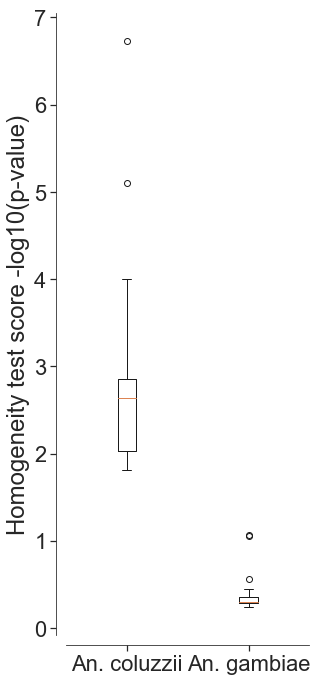

In [94]:
fig, ax = plt.subplots(figsize=(5,10))
gambiae_hom = homogen_select_gambiae['score'].list()[:20]
coluzzii_hom  = homogen_select_coluzzii['score'].list()[:20]
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)

fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top20_allgenes_v2.png', dpi=500)

## Plot the distribution of the homogen test genes under private selection

In [95]:
priv_sel_gambiae

chrom,gene,segreg_c,pri_der_fix_c,score_c,segreg_g,pri_der_fix_g,score_g
X,AGAP000975,None,None,0,13,5,53.942333369
X,AGAP001083,11,1,0.868047859711,7,3,30.4699329669
X,AGAP000837,106,2,0.450340395179,108,9,27.4315459284
2L,AGAP004698,None,None,0,11,3,21.718307862
X,AGAP000010,19,1,0.505135706198,13,3,18.9776377051


In [96]:
private_hom_gambiae = homogen_select_gambiae.join(priv_sel_gambiae, key='gene').sort('score', reverse=True)
private_hom_gambiae.rowlengths()

length,count
10,22


In [97]:
private_hom_coluzzii = homogen_select_coluzzii.join(priv_sel_coluzzii, key='gene').sort('score', reverse=True)
private_hom_coluzzii.rowlengths()

length,count
10,35


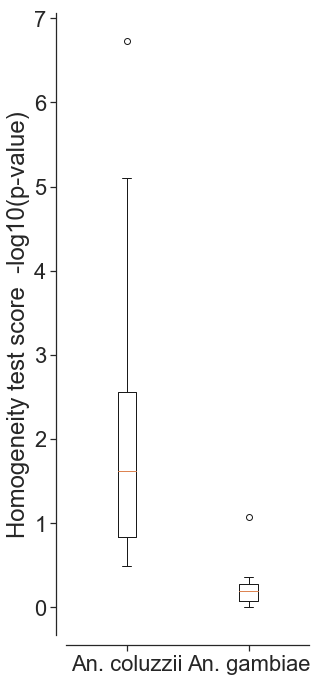

In [100]:
fig, ax = plt.subplots(figsize=(5,10))
gambiae_hom = private_hom_gambiae['score'].list()
coluzzii_hom  = private_hom_coluzzii['score'].list()[:22]
ax.boxplot([coluzzii_hom, gambiae_hom])
#sns.boxplot([coluzzii_hom, gambiae_hom], ax=ax)
ax.set_xticklabels(['An. coluzzii', 'An. gambiae'])
ax.set_ylabel('Homogeneity test score  -log10(p-value)')
sns.set(style ='ticks',font_scale=2)
sns.despine(offset=10)
fig.tight_layout()
#plt.savefig('/home/randomx/hka/homogen_test/distribution_top11_private_selec_v2.png', dpi=500)

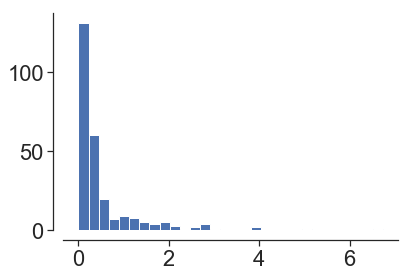

In [101]:
#plot homog score distribution
fig, ax = plt.subplots()
x = [float(i) for i in homog_tbl['score'].list()]
val = ax.hist(x, bins=30)
sns.despine(offset=10)